In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

In [34]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv('D:/Download/movielens/ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv('D:/Download/movielens/ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('D:/Download/movielens/ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [35]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [36]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


In [37]:
movies.head(10)

,MovieID,Title,Genres
0,1,"[1041, 11, 4413, 4413, 4413, 4413, 4413, 4413,...","[6, 15, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
1,2,"[2039, 4413, 4413, 4413, 4413, 4413, 4413, 441...","[12, 15, 18, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,3,"[3466, 1600, 1969, 4413, 4413, 4413, 4413, 441...","[1, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
3,4,"[1071, 5073, 3963, 4413, 4413, 4413, 4413, 441...","[1, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
4,5,"[66, 4761, 3483, 4508, 4960, 3577, 4413, 4413,...","[1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
5,6,"[4819, 4413, 4413, 4413, 4413, 4413, 4413, 441...","[16, 10, 14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
6,7,"[2330, 4413, 4413, 4413, 4413, 4413, 4413, 441...","[1, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
7,8,"[3010, 3308, 4470, 4413, 4413, 4413, 4413, 441...","[12, 15, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
8,9,"[3837, 1819, 4413, 4413, 4413, 4413, 4413, 441...","[16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
9,10,"[2436, 4413, 4413, 4413, 4413, 4413, 4413, 441...","[16, 12, 14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


In [38]:
movies.values[0]

array([1,
       list([1041, 11, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413]),
       list([6, 15, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])],
      dtype=object)

In [39]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

In [40]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


In [41]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [42]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = '.\save'

In [43]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

In [44]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [45]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    #第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    #第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

In [46]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

In [47]:
def get_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
#     movie_categories_embed_layer = tf.keras.layers.Reshape([1, 18 * embed_dim])(movie_categories_embed_layer)

    return movie_categories_embed_layer

In [48]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    #Dropout层
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

In [49]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    #第一层全连接
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    #第二层全连接
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

In [50]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = ".\models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # 获取输入占位符
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        # 获取User的4个嵌入向量
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender,
                                                                                                   user_age, user_job)
        # 得到用户特征
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
        # 获取电影ID的嵌入向量
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
        # 获取电影类型的嵌入向量
        movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
        # 获取电影名的特征向量
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
        # 得到电影特征
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)
        # 计算出评分
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        
        # 将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],
#                                                       1)  # (?, 400)
        # 你可以使用下面这个全连接层，试试效果
        #inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(
        #    inference_layer)
#         inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE损失，将计算值回归到评分
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        #         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        #         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            # 将数据集分成训练集和测试集，随机种子不固定
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            #             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                #                 avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    #                     avg_mae(metrics)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        #                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        #     self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        # avg_mae.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            #             with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # 保存测试损失
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions

In [51]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [52]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166880      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 1, 8)     520         reshape_1[0][0]                  
____________________________________________________________________________________________

__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 200)       19400       concatenate_3[0][0]              
__________________________________________________________________________________________________
user_combine_layer_flat (Reshap (None, 200)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
movie_combine_layer_flat (Resha (None, 200)          0           dense_3[0][0]                    
__________________________________________________________________________________________________
inference (Lambda)              (None,)              0           user_combine_layer_flat[0][0]    
                                                                 movie_combine_layer_flat[0][0]   
__________________________________________________________________________________________________
lambda_3 (

Step #87750	Epoch   1 Batch  249/3125   Loss: 0.716507 mae: 0.634476 (45.12489566834551 steps/sec)
Step #87800	Epoch   1 Batch  299/3125   Loss: 0.645914 mae: 0.633915 (45.74227438009751 steps/sec)
Step #87850	Epoch   1 Batch  349/3125   Loss: 0.643895 mae: 0.637030 (45.86797149436731 steps/sec)
Step #87900	Epoch   1 Batch  399/3125   Loss: 0.704419 mae: 0.636455 (45.043791548919444 steps/sec)
Step #87950	Epoch   1 Batch  449/3125   Loss: 0.672821 mae: 0.642328 (44.92273827621862 steps/sec)
Step #88000	Epoch   1 Batch  499/3125   Loss: 0.625386 mae: 0.631790 (45.74243401472333 steps/sec)
Step #88050	Epoch   1 Batch  549/3125   Loss: 0.623798 mae: 0.628704 (45.57603322093364 steps/sec)
Step #88100	Epoch   1 Batch  599/3125   Loss: 0.556432 mae: 0.637803 (45.1661312595893 steps/sec)
Step #88150	Epoch   1 Batch  649/3125   Loss: 0.666210 mae: 0.634620 (43.181502772105084 steps/sec)
Step #88200	Epoch   1 Batch  699/3125   Loss: 0.668544 mae: 0.636290 (45.369881601196276 steps/sec)
Step #88

Step #91800	Epoch   2 Batch 1174/3125   Loss: 0.568053 mae: 0.637550 (20.231510034323545 steps/sec)
Step #91850	Epoch   2 Batch 1224/3125   Loss: 0.685416 mae: 0.627403 (18.072714436992587 steps/sec)
Step #91900	Epoch   2 Batch 1274/3125   Loss: 0.673809 mae: 0.642907 (19.439183587510584 steps/sec)
Step #91950	Epoch   2 Batch 1324/3125   Loss: 0.555133 mae: 0.633912 (22.57256008526363 steps/sec)
Step #92000	Epoch   2 Batch 1374/3125   Loss: 0.640595 mae: 0.625325 (23.481849465269594 steps/sec)
Step #92050	Epoch   2 Batch 1424/3125   Loss: 0.658137 mae: 0.631871 (23.437936216329547 steps/sec)
Step #92100	Epoch   2 Batch 1474/3125   Loss: 0.528345 mae: 0.633236 (22.046496127950817 steps/sec)
Step #92150	Epoch   2 Batch 1524/3125   Loss: 0.583370 mae: 0.629175 (24.843207131011823 steps/sec)
Step #92200	Epoch   2 Batch 1574/3125   Loss: 0.718623 mae: 0.632645 (24.68428300709754 steps/sec)
Step #92250	Epoch   2 Batch 1624/3125   Loss: 0.680240 mae: 0.624754 (22.767332017331448 steps/sec)
St

Step #95850	Epoch   3 Batch 2099/3125   Loss: 0.634828 mae: 0.622448 (41.74337309779861 steps/sec)
Step #95900	Epoch   3 Batch 2149/3125   Loss: 0.578579 mae: 0.620820 (41.81299322846084 steps/sec)
Step #95950	Epoch   3 Batch 2199/3125   Loss: 0.608263 mae: 0.628039 (42.45023541271107 steps/sec)
Step #96000	Epoch   3 Batch 2249/3125   Loss: 0.557825 mae: 0.625322 (42.77618316425353 steps/sec)
Step #96050	Epoch   3 Batch 2299/3125   Loss: 0.670854 mae: 0.635963 (43.144369070136506 steps/sec)
Step #96100	Epoch   3 Batch 2349/3125   Loss: 0.674169 mae: 0.627665 (42.27131906384986 steps/sec)
Step #96150	Epoch   3 Batch 2399/3125   Loss: 0.576751 mae: 0.627449 (42.8128078797621 steps/sec)
Step #96200	Epoch   3 Batch 2449/3125   Loss: 0.622981 mae: 0.626261 (42.776209339794924 steps/sec)
Step #96250	Epoch   3 Batch 2499/3125   Loss: 0.763871 mae: 0.637851 (42.776244240566605 steps/sec)
Step #96300	Epoch   3 Batch 2549/3125   Loss: 0.541268 mae: 0.633332 (42.66703993382104 steps/sec)
Step #96

Step #99900	Epoch   4 Batch 3024/3125   Loss: 0.596423 mae: 0.620695 (46.7665619011047 steps/sec)
Step #99950	Epoch   4 Batch 3074/3125   Loss: 0.655814 mae: 0.618581 (46.248783218090985 steps/sec)
Step #100000	Epoch   4 Batch 3124/3125   Loss: 0.728644 mae: 0.625211 (46.03619143872318 steps/sec)

Train time for epoch #5 (100000 total steps): 70.17970180511475
Model test set loss: 0.755231 mae: 0.679529


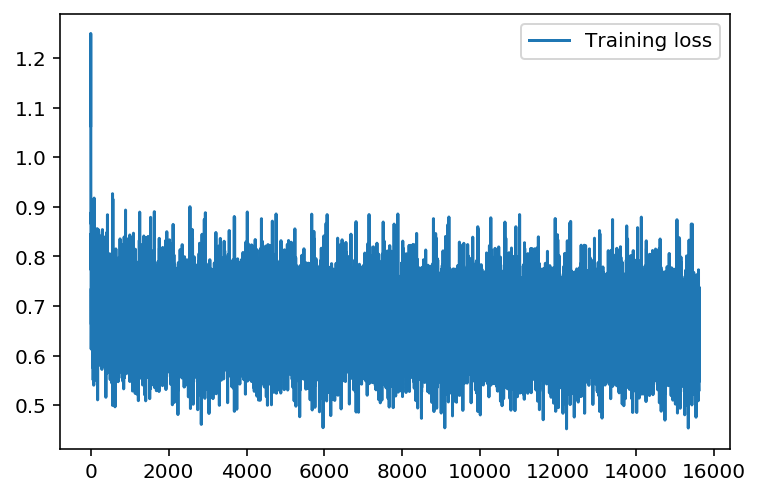

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

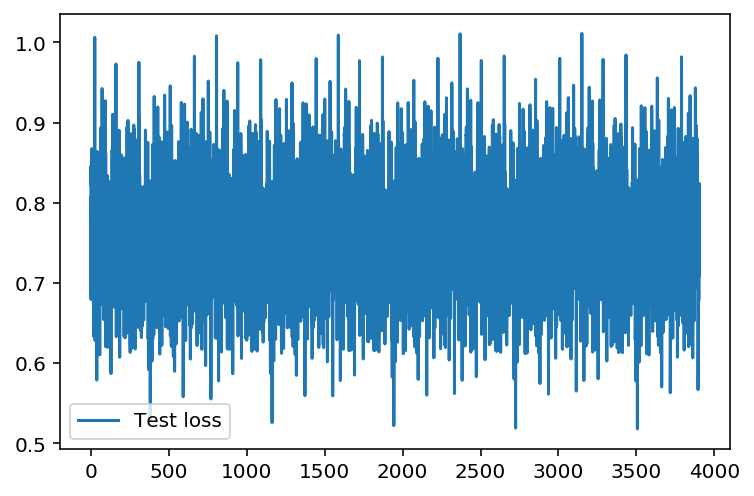

In [55]:
plt.plot(mv_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [56]:
def rating_movie(mv_net, user_id_val, movie_id_val):
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    inference_val = mv_net.model([np.reshape(users.values[user_id_val-1][0], [1, 1]),
              np.reshape(users.values[user_id_val-1][1], [1, 1]),
              np.reshape(users.values[user_id_val-1][2], [1, 1]),
              np.reshape(users.values[user_id_val-1][3], [1, 1]),
              np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              categories,  
              titles])

    return (inference_val.numpy())

In [57]:
rating_movie(mv_net, 234, 1401)

array([[4.2519937]], dtype=float32)

In [58]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6]], 
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [59]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2], mv_net.model.input[3]], 
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [60]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    #推荐同类型的电影
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [62]:
recommend_same_type_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
1443
[1471 'Boys Life 2 (1997)' 'Drama']
1380
[1401 'Ghosts of Mississippi (1996)' 'Drama']
357
[361 'It Could Happen to You (1994)' 'Drama|Romance']
3344
[3413 'Impact (1949)' 'Crime|Drama']
3345
[3414 'Love Is a Many-Splendored Thing (1955)' 'Romance']


{357, 1380, 1443, 3344, 3345}

In [63]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    #推荐您喜欢的电影
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [69]:
recommend_your_favorite_movie(222, 10)

以下是给您的推荐：
1120
[1136 'Monty Python and the Holy Grail (1974)' 'Comedy']
777
[787 'Gate of Heavenly Peace, The (1995)' 'Documentary']
1179
[1197 'Princess Bride, The (1987)' 'Action|Adventure|Comedy|Romance']
3483
[3552 'Caddyshack (1980)' 'Comedy']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']


{777, 1120, 1179, 1180, 3483}

In [65]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    #     print(normalized_users_matrics.numpy().shape)
    #     print(probs_user_favorite_similarity.numpy()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
    p = np.argmax(sim, 1)
    print("喜欢看这个电影的人还喜欢看：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [68]:
recommend_other_favorite_movie(1400, 20)

您看的电影是：[1400 'Somebody is Waiting (1996)' 'Drama']
喜欢看这个电影的人是：[[1268 'M' 50 2]
 [5641 'F' 25 17]
 [1939 'F' 35 2]
 [3304 'F' 45 5]
 [3295 'M' 18 18]
 [3871 'M' 18 4]
 [763 'M' 18 10]
 [4754 'F' 18 0]
 [566 'M' 25 17]
 [3579 'M' 18 0]
 [4371 'F' 18 4]
 [4722 'M' 35 12]
 [1855 'M' 18 4]
 [3460 'M' 1 4]
 [2338 'M' 45 17]
 [209 'M' 35 1]
 [3323 'M' 35 14]
 [3901 'M' 18 14]
 [4557 'M' 25 14]
 [282 'M' 25 17]]
喜欢看这个电影的人还喜欢看：
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
2502
[2571 'Matrix, The (1999)' 'Action|Sci-Fi|Thriller']
3538
[3607 'One Little Indian (1973)' 'Comedy|Drama|Western']
1399
[1423 'Hearts and Minds (1996)' 'Drama']
1175
[1192 'Paris Is Burning (1990)' 'Documentary']


{1175, 1399, 2434, 2502, 3538}